# This is a document that tries keras on jupyter notebook

## Several notes for 11.17
1. Normalizing input data is essential
2. for categorical result, even though there are only two categories, use multi output and softmax. This is necessary as for calculating output in real cases, there are more variables to compare to, thus higher security of a good result.
3. From my guesses, using BN after concatenating two different vectors might alleviate the fitting effort during training, but this remain to be seen
4. Design the network structure with your heart, dude!

In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
import re
from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from kerastoolbox.visu import plot_weights
import time
%matplotlib notebook

Using TensorFlow backend.


In [2]:
# visualization tool
class RealTimeVisualizer(Callback):
    def on_train_begin(self, logs={}):
        self.fig, (self.ax1, self.ax2) = plt.subplots(2,1, sharex=True)
        self.fig.set_size_inches(20, 8)
        self.index_graph = []
        self.loss_graph = []
        self.val_loss_graph = []
        self.acc_graph = []
        self.val_acc_graph = []
 
    def on_epoch_end(self, epoch, logs={}):
        interval = self.interval
        loss = logs['loss']
        val_loss = logs['val_loss']
        val_acc = logs['val_acc']
        acc = logs['acc']
        if epoch%interval == interval-1:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc
            self.loss_graph[int(epoch/interval)] /= interval
            self.val_loss_graph[int(epoch/interval)] /= interval
            self.val_acc_graph[int(epoch/interval)] /= interval
            self.acc_graph[int(epoch/interval)] /= interval
            self.ax1.set_title("loss is:{} val_loss is:{}".format(loss, val_loss))
            self.ax1.plot(self.index_graph, self.loss_graph, '-r')
            self.ax1.plot(self.index_graph, self.val_loss_graph, '-xb')
            self.ax2.set_title("acc is:{} val_acc is:{}".format(acc, val_acc))
            self.ax2.plot(self.index_graph, self.acc_graph, '-r')
            self.ax2.plot(self.index_graph, self.val_acc_graph, '-xb')
            self.ax2.plot(self.index_graph, [0.5]*len(self.index_graph), '-p')
            self.fig.canvas.draw()
            time.sleep(0.05)
        elif epoch%interval == 0:
            self.loss_graph.append(loss)
            self.val_loss_graph.append(val_loss)
            self.val_acc_graph.append(val_acc)
            self.acc_graph.append(acc)
            self.index_graph.append(epoch)
        else:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc

VisualizeCallback = RealTimeVisualizer()
VisualizeCallback.interval = 20

In [148]:
def is_desired_letter(char):
    return ord(char) >= 97 and ord(char) < 123 or ord(char) >= 48 and ord(char) < 58 or ord(char) == ord(" ")


# return even number of 0 and 1 if is_even_result is True
def get_train_data(train_portion, is_even_result=True):
    # make data replicable
    np.random.seed(7)
    # load the dataset but only keep the top n words, zero the rest
    train_data = pd.read_csv("../input/kickstarter_train.csv")

    # even the result so that 1 : 0 = 1 : 1
    if is_even_result:
        # count 0 and drop some until sample of 1 = sample of 0
        status_count = train_data.iloc[:, -1].value_counts().to_dict()
        drop_zero_num = status_count[0] - status_count[1]
        drop_zero_p = drop_zero_num / float(status_count[0])
        drop_index = []
        for i in range(len(train_data)):
            if train_data.iloc[i, -1] == 0:
                if np.random.uniform(low=0, high=1) < drop_zero_p:
                    drop_index.append(i)
        train_data = train_data.drop(train_data.index[drop_index])
        status_count = train_data.iloc[:, -1].value_counts().to_dict()
        print("balanced data has a portion between 0 and 1 of: ", float(status_count[0]) / float(status_count[1]))
        # shuffle the whole data
        train_data = train_data.sample(frac=1).reset_index(drop=True)
        
    # tokenize all countries
    countries = list(train_data.iloc[:, 6])
    # load dictionary or genrate one online
    try:
        country_dict = Dictionary.load("num_data/country_dict.pkl")
        print("loading country dictionary successful from disk")
    except:
        print("No country dictionary available, generating from data")
        country_dict = Dictionary([countries])
        country_dict.save("num_data/country_dict.pkl")
        print("new dictionary saved to num_data")
    # start tokenization
    try:
        countries = list(map(country_dict.token2id.get, countries)) # map gives extra speed~
    except:
        print("Warning!!! A country that does not exist in current dictionary!!!")

    # spliting input output
    # get split point for train and test data
    split_point = int(train_portion * len(train_data))
    # get num data
    train_num = np.array(train_data.iloc[:split_point, [3, 12]])
    test_num = np.array(train_data.iloc[split_point:, [3, 12]])
    # get country data
    train_country = np.array(countries[:split_point])
    test_country = np.array(countries[split_point:])
    # get result data
    train_results = np.array([[1, 0] if item == 1 else [0, 1] for item in train_data.iloc[:split_point, -1]])
    test_results = np.array([[1, 0] if item == 1 else [0, 1] for item in train_data.iloc[split_point:, -1]])
    
    return [train_num, train_country, train_results], [test_num, test_country, test_results]

# preprocessing input nums
def preprocess_num_data(data_num, scale=[]):
    data_num_unzip = list(zip(*data_num))
    for i, col in enumerate(data_num_unzip):
        if scale[i] != 0: # if scale for a col is set to 0, then we do not change that col
            maximum = max(col)
            data_num_unzip[i] = [(item / maximum * 2 - 1)*scale[i] for item in col]
    data_num = np.array(list(zip(*data_num_unzip))) # zip and zip(* is similar to transpose
    return data_num

In [149]:
# get training testing data from disk
train_data_portion = 0.4
train_data, test_data = get_train_data(train_data_portion)
print("data grabbed, length is:", len(testY)+len(trainY))

balanced data has a portion between 0 and 1 of:  1.0004050808715026
No country dictionary available, generating from data
new dictionary saved to num_data
data grabbed, length is: 69196


In [150]:
# preprocess num_data
scale = np.array([1, 1])
train_data[0] = preprocess_num_data(train_data[0], scale)
test_data[0] = preprocess_num_data(test_data[0], scale)
print("number has been converted to a smaller region of:[{}]".format(list(zip(scale, -scale))))

number has been converted to a smaller region of:[[(1, -1), (1, -1)]]


In [151]:
print(train_data[1].max())

10


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 1, 4)         44          input_42[0][0]                   
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 4)            0           embedding_23[0][0]               
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 4)            16          reshape_12[0][0]                 
__________________________________________________________________________________________________
input_43 (

<IPython.core.display.Javascript object>


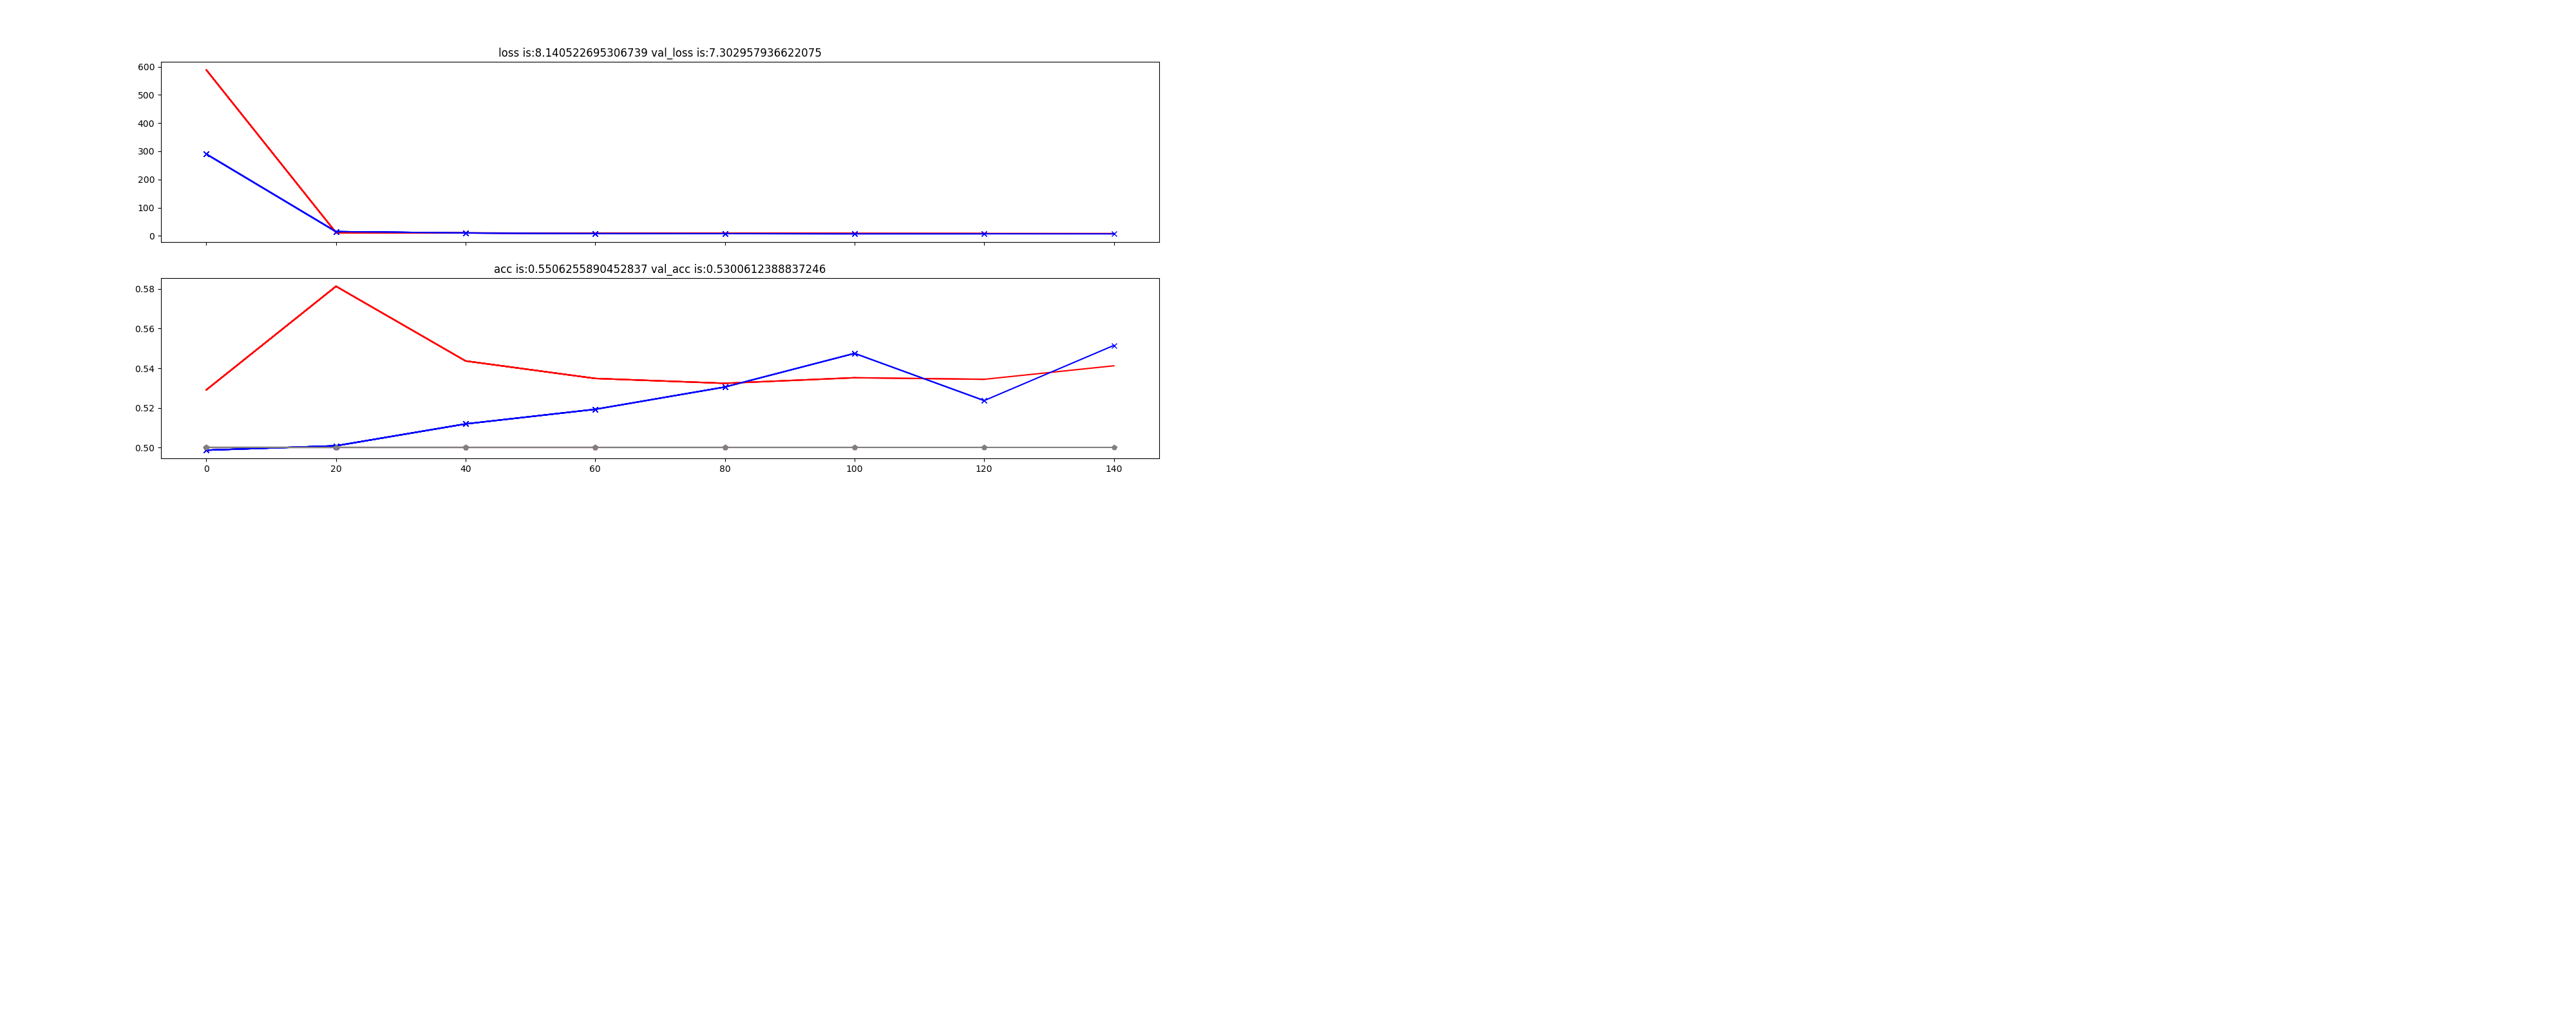

In [ ]:
# generate autoencoding model for num data
# first construct embedding for country code
embed_vec = 4
input_dim = len(Dictionary.load("num_data/country_dict.pkl"))
country_input = Input(shape=(1,))
country_embed = Embedding(input_length=1, output_dim=embed_vec, input_dim=input_dim)(country_input)
country_embed = Reshape(target_shape=(embed_vec,))(country_embed)
country_embed = BatchNormalization()(country_embed)
country_embed = Activation("tanh")(country_embed)
# concatenate other inputs with the embedding
numerical_input = Input(shape=(2,))
all_num_input = concatenate(inputs=[numerical_input, country_embed])
# formulate the rest of the net
x = all_num_input
x = Dense(units=256, activity_regularizer=l1(0.01), name="num_dense_1")(x)
x = Activation("tanh")(x)
x = Dropout(0.5)(x)
x = Dense(units=256, activity_regularizer=l1(0.01), name="num_dense_2")(x)
x = BatchNormalization(name="num_bn_1")(x)
x = Activation("tanh")(x)
x = Dropout(0.5)(x)
num_model_output = Dense(units=2, activation="softmax")(x)
# model the model
num_model = Model(inputs=[numerical_input, country_input], outputs=[num_model_output])

# configure network for training
num_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=["accuracy"])
print("model building finished\n", num_model.summary())

# do training
num_model.fit(train_data[0:2], train_data[2], epochs=5000, batch_size=5000, shuffle=True,
                  verbose=0, validation_data=[test_data[0:2], test_data[2]], 
                  callbacks=[ReduceLROnPlateau(patience=50, min_lr=0.00001, cooldown=100), VisualizeCallback])
num_model.save_weights("num_model_weights.h5")

In [161]:
# generate pretrain model for num data
num_model.layers.pop()
x = Dense(units=2, activation="softmax")(num_model.layers[-1].output)
num_model = Model(inputs=num_model.input, outputs=[x])

# Plot things out can really help!!!
> This happens when your math cannot help you understand the situation. 
> This will work if your graph intuition is good

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 1, 4)         44          input_34[0][0]                   
__________________________________________________________________________________________________
input_35 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 4)            0           embedding_19[0][0]               
__________________________________________________________________________________________________
concatenat

<IPython.core.display.Javascript object>


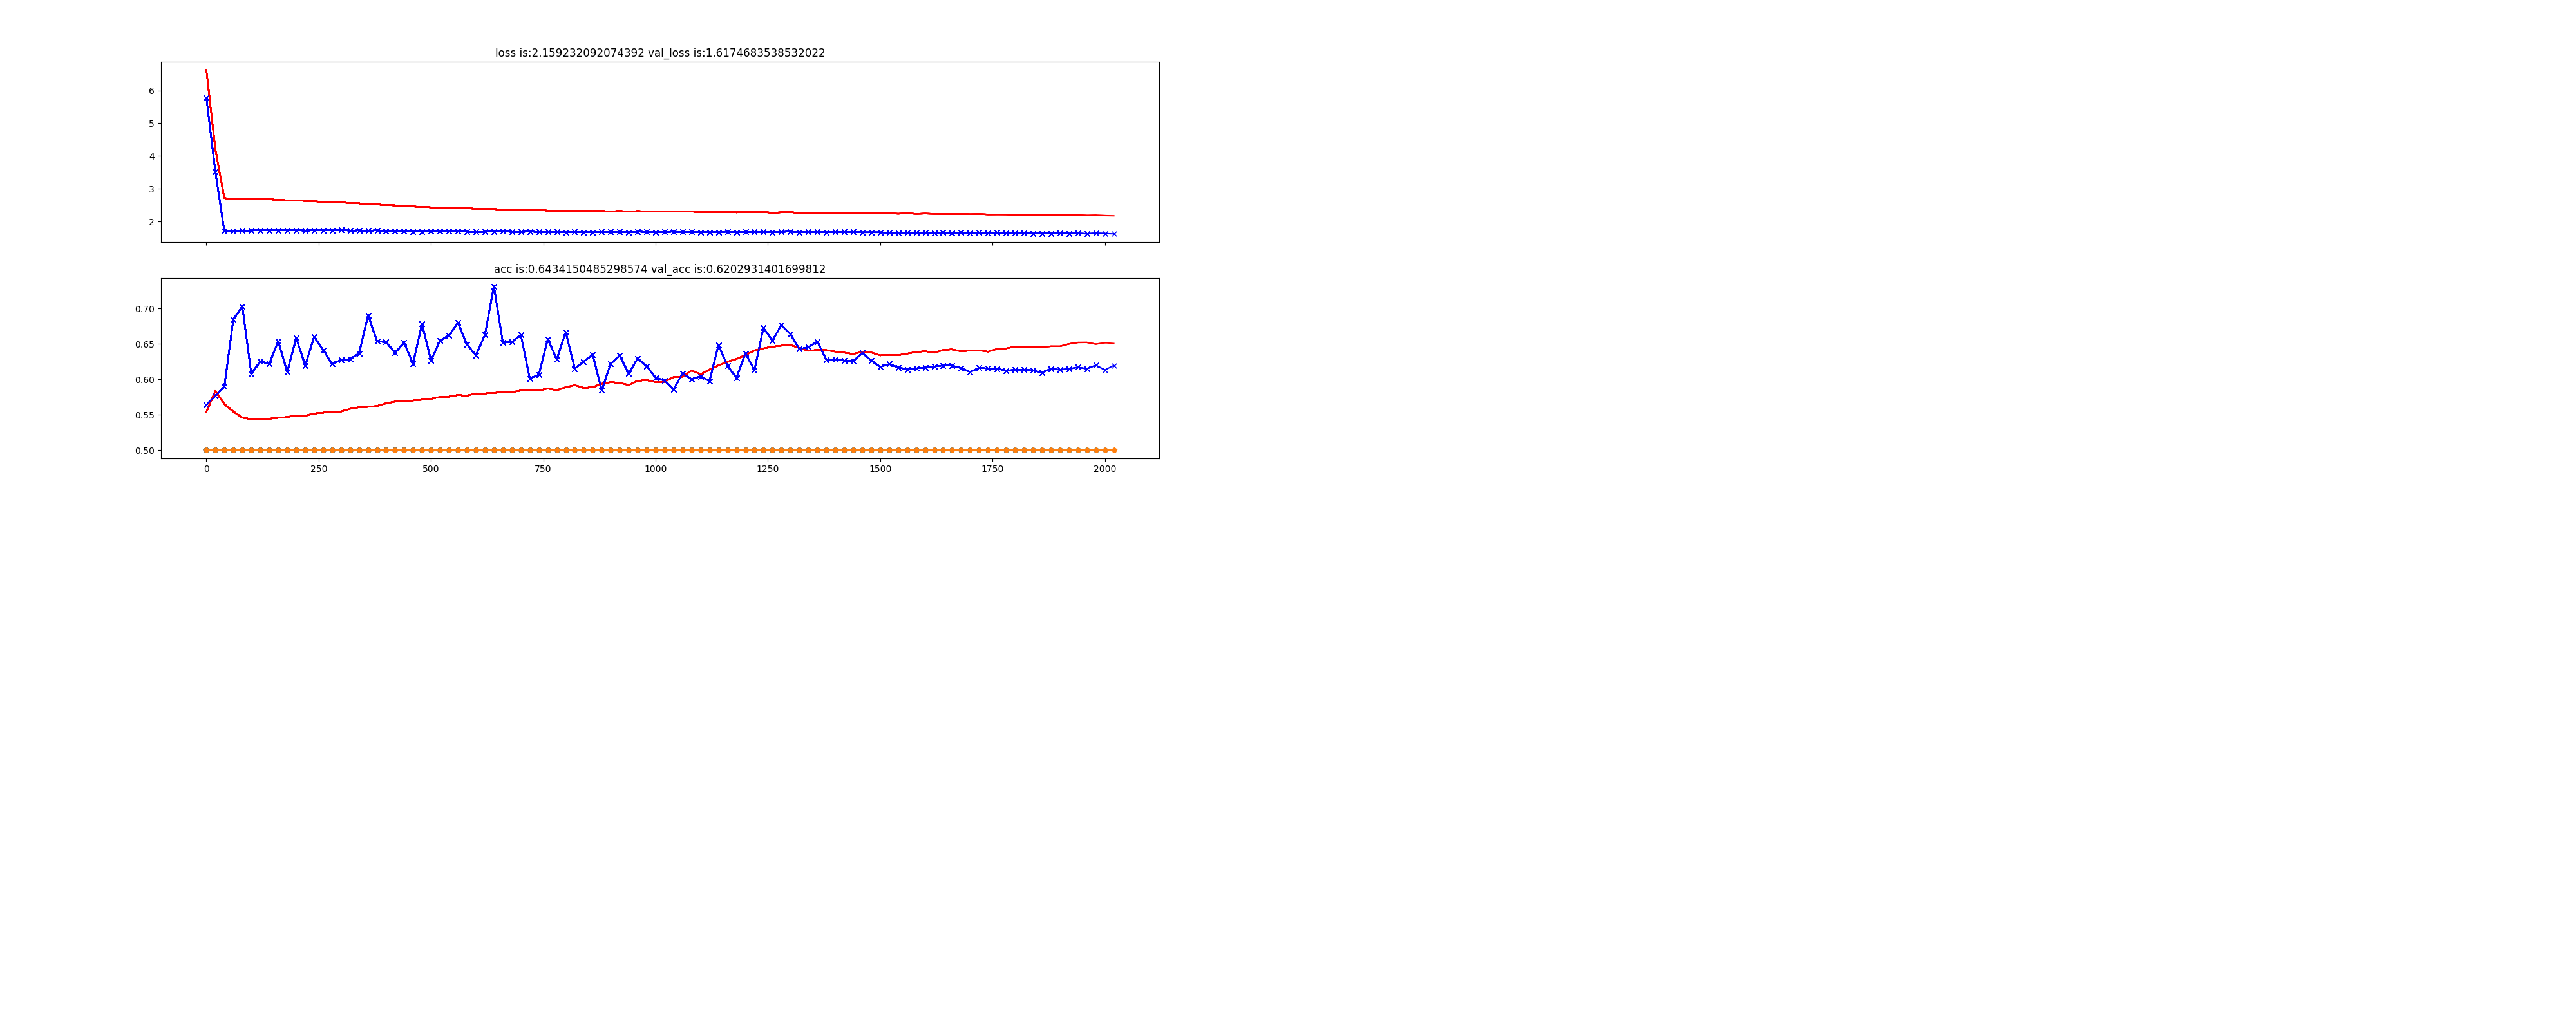

KeyboardInterrupt: 

In [163]:
# configure network for traini

In [21]:
zeros = 0.0
ones = 0.0
for i in testY:
    if i[0] == 0:
        zeros += 1
    else:
        ones += 1
print("frequency of zero is: ", zeros/(ones+zeros))

result = [1 if item[0] > item[1] else 0 for item in hybrid_model.predict_on_batch([testX_num, testX_desc])]
result = list(zip(result, list(zip(*testY))[0]))
predict_for_ones = np.array([1 for item in result if item[0] == item[1] and item[1] == 1])
right = float(len(predict_for_ones))
total = len([1 for item in result if item[0] == 1])
print("accurate prediction for 1 is: ",   right / total)
print("right guesses in all: ", right / len(result))
print("number of right is: ", right)

frequency of zero is:  0.48847926267281105
accurate prediction for 1 is:  0.6671318911374738
right guesses in all:  0.42634160844358554
number of right is:  2868.0
